In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
car_dataset.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,high,vhigh,3,more,med,high,unacc
1,low,med,3,2,big,med,unacc
2,high,med,4,more,med,med,acc
3,med,high,3,4,med,high,acc
4,vhigh,med,5more,more,big,high,acc


unacc    562
acc      180
good      35
vgood     28
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

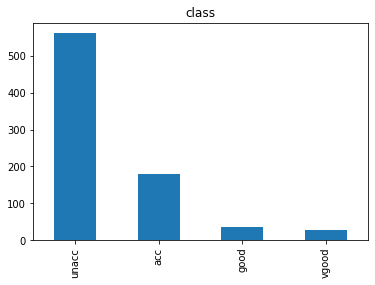

In [7]:
car_set_for_training, car_testing = data_utils.data_split(car_dataset, 70)
car_training, car_validation = data_utils.split_training_data_for_pruning(car_set_for_training)
print(car_training['CLASS'].value_counts())
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [8]:
car_training

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,high,vhigh,3,more,med,high,unacc
1,low,med,3,2,big,med,unacc
2,high,med,4,more,med,med,acc
3,med,high,3,4,med,high,acc
4,vhigh,med,5more,more,big,high,acc
...,...,...,...,...,...,...,...
800,low,vhigh,4,2,small,med,unacc
801,low,med,2,2,big,med,unacc
802,low,high,3,more,small,low,unacc
803,low,med,3,more,small,med,acc


<AxesSubplot:title={'center':'class'}>

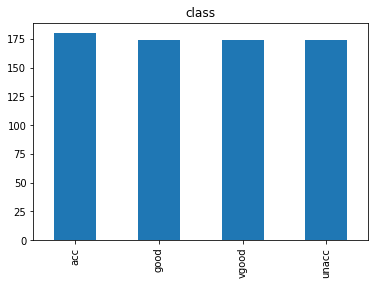

In [9]:
#Target for all 174
resampling_car = car_training.copy()
unacc_part = resampling_car[resampling_car['CLASS'] == 'unacc']
acc_part = resampling_car[resampling_car['CLASS'] == 'acc'] 
vgood_part = resampling_car[resampling_car['CLASS'] == 'vgood'] 
good_part = resampling_car[resampling_car['CLASS'] == 'good'] 


unacc_downsample = resample(unacc_part, 
                                 replace=False,     
                                 n_samples=174)

vgood_part_upsampled = resample(vgood_part, 
                                 replace=True,     
                                 n_samples=174)
good_part_upsampled = resample(good_part, 
                                 replace=True,     
                                 n_samples=174)

# Combine majority class with upsamplet minority class
balanced_car_training= pd.concat([unacc_downsample, acc_part, vgood_part_upsampled, good_part_upsampled])
balanced_car_training = balanced_car_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training = balanced_car_training.sample(frac=1).reset_index(drop=True)

car_training = balanced_car_training.copy()
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [10]:
car_training.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,med,3,4,med,high,good
1,low,low,3,more,med,med,good
2,high,low,2,4,small,high,acc
3,med,high,3,more,med,high,acc
4,low,low,4,4,small,high,good


## Model Training

In [11]:
train_tree_for_different_heuristics(car_training, car_testing, car_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 44.32% | training 69.52% | levels 10 | leafs 28
After Pruning:
Accuracy for: testing 68.21% | training 53.42% | levels 10 | leafs 9


Before Pruning - heuristic = info_gain
Accuracy for: testing 50.87% | training 70.37% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 63.78% | training 57.69% | levels 10 | leafs 16


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 49.52% | training 70.37% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 66.67% | training 57.69% | levels 10 | leafs 16


Before Pruning - heuristic = distance_measure
Accuracy for: testing 49.33% | training 53.42% | levels 10 | leafs 30
After Pruning:
Accuracy for: testing 62.24% | training 46.58% | levels 10 | leafs 16


Before Pruning - heuristic = j_measure
Accuracy for: testing 42.58% | training 68.09% | levels 10 | leafs 29
After Pruning:
Accuracy for: testing 66.67% | training 55.56% | levels 10 |

# CMC Dataset

## Dataset preparation

In [12]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,24,1,3,4,1,1,3,3,0,3
1,29,4,4,3,1,1,3,4,0,3
2,27,4,4,3,1,1,1,4,0,2
3,23,4,4,1,1,0,3,3,0,1
4,21,3,3,1,1,0,3,2,0,1


In [13]:
vals_to_replace_education = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_husbandEducation = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_religion = {0: 'Non-Islam', 1:'Islam'}
vals_to_replace_isWorking = {0: 'Yes', 1:'No'}
vals_to_replace_livingStandard= {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_mediaExposure = {0: 'Good', 1:'Not good'}
vals_to_replace_CLASS = {1: 'No-use', 2:'Long-term', 3: 'Short-term'}
cmc_dataset['education'] = cmc_dataset['education'].map(vals_to_replace_education)
cmc_dataset['husbandEducation'] = cmc_dataset['husbandEducation'].map(vals_to_replace_husbandEducation)
cmc_dataset['religion'] = cmc_dataset['religion'].map(vals_to_replace_religion)
cmc_dataset['isWorking'] = cmc_dataset['isWorking'].map(vals_to_replace_isWorking)
cmc_dataset['livingStandard'] = cmc_dataset['livingStandard'].map(vals_to_replace_livingStandard)
cmc_dataset['mediaExposure'] = cmc_dataset['mediaExposure'].map(vals_to_replace_mediaExposure)
cmc_dataset['CLASS'] = cmc_dataset['CLASS'].map(vals_to_replace_CLASS)

In [14]:
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,24,low,normal,4,Islam,No,3,normal,Good,Short-term
1,29,high,high,3,Islam,No,3,high,Good,Short-term
2,27,high,high,3,Islam,No,1,high,Good,Long-term
3,23,high,high,1,Islam,Yes,3,normal,Good,No-use
4,21,normal,normal,1,Islam,Yes,3,medium,Good,No-use


No-use        289
Short-term    229
Long-term     169
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

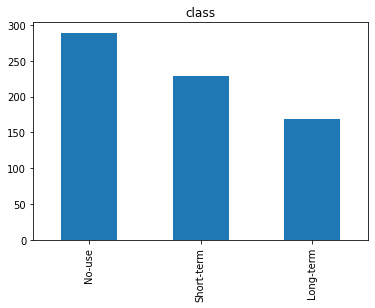

In [15]:
cmc_set_for_training, cmc_testing = data_utils.data_split(cmc_dataset, 70)
cmc_training, cmc_validation = data_utils.split_training_data_for_pruning(cmc_set_for_training)
print(cmc_training['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [16]:
train_tree_for_different_heuristics(cmc_training, cmc_testing, cmc_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 47.74% | training 80.35% | levels 36 | leafs 167
After Pruning:
Accuracy for: testing 52.26% | training 62.01% | levels 36 | leafs 53


Before Pruning - heuristic = info_gain
Accuracy for: testing 45.48% | training 70.60% | levels 46 | leafs 184
After Pruning:
Accuracy for: testing 44.34% | training 54.88% | levels 32 | leafs 85


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 45.25% | training 69.87% | levels 48 | leafs 202
After Pruning:
Accuracy for: testing 42.76% | training 42.21% | levels 10 | leafs 8


Before Pruning - heuristic = distance_measure
Accuracy for: testing 39.14% | training 56.91% | levels 38 | leafs 164
After Pruning:
Accuracy for: testing 42.08% | training 48.62% | levels 30 | leafs 72


Before Pruning - heuristic = j_measure
Accuracy for: testing 44.57% | training 71.03% | levels 46 | leafs 185
After Pruning:
Accuracy for: testing 43.67% | training 52.69% | levels

# Adult Dataset

## Data preparation

In [17]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,90,Private,87285,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,24,United-States,<=50K
1,47,Federal-gov,380127,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,56,Local-gov,264436,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,35,Private,106967,Masters,14,Never-married,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,66,?,107112,7th-8th,4,Never-married,?,Other-relative,Black,Male,0,0,30,United-States,<=50K


In [18]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week','CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,CLASS
0,90,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,24,<=50K
1,47,Federal-gov,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,40,<=50K
2,56,Local-gov,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,40,<=50K
3,35,Private,Masters,14,Never-married,Sales,Not-in-family,White,Female,40,<=50K
4,66,?,7th-8th,4,Never-married,?,Other-relative,Black,Male,30,<=50K


In [19]:
adult_dataset['education-num'].where(adult_dataset['education-num'] > 10)

0         NaN
1         NaN
2         NaN
3        14.0
4         NaN
         ... 
32556    11.0
32557     NaN
32558     NaN
32559     NaN
32560     NaN
Name: education-num, Length: 32561, dtype: float64

<=50K    11443
>50K      3751
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

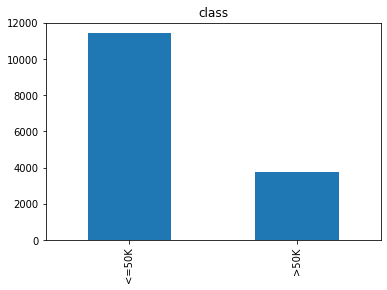

In [20]:
adult_set_for_training, adult_testing = data_utils.data_split(adult_dataset, 70)
adult_training, adult_validation = data_utils.split_training_data_for_pruning(adult_set_for_training)

print(adult_training['CLASS'].value_counts())
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

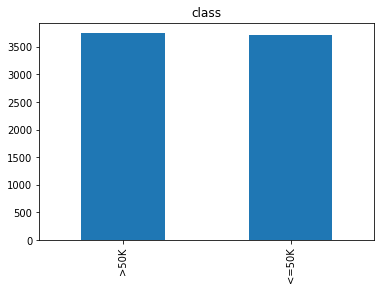

In [21]:
resampling_adult = adult_training.copy()
less_50k_part = resampling_adult[resampling_adult['CLASS'] == '<=50K']
more_50k_part = resampling_adult[resampling_adult['CLASS'] == '>50K'] 

less_50k_part_downsampled = resample(less_50k_part, 
                                 replace=False,    
                                 n_samples=3706)

# Combine minority class with downsampled majority class
balanced_adult_training = pd.concat([less_50k_part_downsampled, more_50k_part])
balanced_adult_training = balanced_adult_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training = balanced_adult_training.sample(frac=1).reset_index(drop=True)

adult_training = balanced_adult_training.copy()
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [22]:
train_tree_for_different_heuristics(adult_training, adult_testing, adult_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 77.60% | training 81.83% | levels 42 | leafs 231
After Pruning:
Accuracy for: testing 80.54% | training 78.46% | levels 34 | leafs 78


Before Pruning - heuristic = info_gain
Accuracy for: testing 66.39% | training 71.97% | levels 106 | leafs 281
After Pruning:
Accuracy for: testing 74.45% | training 52.14% | levels 40 | leafs 50


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 66.64% | training 71.13% | levels 104 | leafs 282
After Pruning:
Accuracy for: testing 74.45% | training 52.14% | levels 40 | leafs 50


Before Pruning - heuristic = distance_measure
Accuracy for: testing 73.37% | training 77.75% | levels 74 | leafs 284
After Pruning:
Accuracy for: testing 79.10% | training 73.56% | levels 60 | leafs 110


Before Pruning - heuristic = j_measure
Accuracy for: testing 66.14% | training 71.91% | levels 106 | leafs 281
After Pruning:
Accuracy for: testing 74.45% | training 52.14% | l